In [1]:
# import numpy as np
# import torch 
# from torchvision import datasets, transforms
# from utils import * # get the dataset
# from pyhessian import hessian # Hessian computation
# from density_plot import get_esd_plot # ESD plot
# from pytorchcv.model_provider import get_model as ptcv_get_model # model

import matplotlib.pyplot as plt
import itertools
import cvxpy as cvx
from qcqp import *
# %matplotlib inline

In [2]:
# enable cuda devices
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader

In [4]:
from __future__ import absolute_import, division
from __future__ import print_function
import tensorflow as tf
import pickle
import copy
import scipy

# from black import out
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.scipy.special import logsumexp
from autograd import grad, jacobian
from autograd import elementwise_grad as egrad
from autograd.misc.flatten import flatten
from autograd.misc.optimizers import adam

In [6]:
# from torchvision import models
# from torchsummary import summary

# Load Model

In [5]:
# direc = os.path.dirname(os.path.realpath(__file__))
path_read = "C:\\Users\\kmajd1\\Documents\\NNRepLayer_v2\\demos\\examples\\tc1_affine_transform\\tc1\\original_net\\model"
model_orig = tf.keras.models.load_model(path_read)

In [6]:
weights = model_orig.get_weights()

In [7]:
layer_sizes = np.array([3,3,3,3])

In [8]:
ws = []
for w in weights:
    ws = ws + list(w.flatten())
init_params = np.array(ws)

In [9]:
def neural_net_predict(params, inputs, architechture):
    """Implements a deep neural network for classification.
    params is a list of (weights, bias) tuples.
    inputs is an (N x D) matrix.
    returns normalized class log-probabilities."""

    idx = 0
    num_layers = architechture.shape[0] - 1
    for l in range(num_layers):
        inp_dim = architechture[l]
        out_dim = architechture[l + 1]
        num_param = inp_dim * out_dim + out_dim
        W = params[idx : idx + inp_dim * out_dim]
        b = params[idx + inp_dim * out_dim : idx + inp_dim * out_dim + out_dim]
        outputs = np.dot(inputs, W.reshape((inp_dim, out_dim))) + b
        inputs = np.maximum(np.zeros((outputs.shape[0],outputs.shape[1])), outputs)
        idx = idx + inp_dim * out_dim + out_dim

    return outputs

# Load Dataset

In [10]:
def original_data_loader():
    with open ("C:\\Users\\kmajd1\\Documents\\NNRepLayer_v2\\demos\\examples\\tc1_affine_transform\\tc1\\original_net\\data\\input_output_data_tc1.pickle", "rb") as data:
        dataset = pickle.load (data)
    return dataset[0], dataset[1], dataset[2], dataset[3]

In [11]:
x_train, y_train, x_test, y_test = original_data_loader()

# Calculate Hessian

### Cost Function

In [12]:
def soft_plus(x, t=10.): # (1/t) * Ln(1+exp(t*x))
    return (1/t)*np.log(1+np.exp(t*x))
    

Constraint cost:
\begin{aligned}
\sum^{N}_{n=1}\sum^{C}_{c=1} g(A_c y_n-b_c,t)
\end{aligned}
where $g$ is a soft plus function
\begin{aligned}
g(x,t) = \frac{1}{t}\ln{(1+e^{tx})},
\end{aligned}
$C$ is the number of constraints, $t$ is the approximation coefficient, and $N$ is the number of samples.

In [13]:
A = np.array([[-0.70710678,  0.70710678],
   [ 0.70710678,  0.70710678],
   [-0.70710678, -0.70710678],
   [ 0.70710678, -0.70710678]])
b = np.array([[ 1.225     ],
   [ 4.76053391],
   [-2.31053391],
   [ 1.225     ]])
def dist_loss(params):
    y_pred = neural_net_predict(params, x_train, layer_sizes)
    const = np.matmul(A,y_pred[:,0:2].T) - b
    loss = np.sum(
#         np.maximum(np.zeros((const.shape[0],const.shape[1])), const)
        soft_plus(const,10)
    )
    return loss

In [14]:
def objective(params):
    return np.sum((neural_net_predict(params, x_train, layer_sizes) - y_train) ** 2)

###  Hessian

In [25]:
hessian = jacobian(egrad(dist_loss))(init_params)

In [18]:
# check if hessian has a nan value  
if np.isnan(hessian).any():
    print("Hessian has a nan value")
    exit()

In [16]:
from numpy import linalg as la
def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

In [17]:
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

In [21]:
isPD(hessian)
hessian = nearestPD(hessian)
isPD(B)

True

### Find Sparse Eigenvectors for Hessian

In [18]:
def get_weight_range(arch, layer):
    idx = 0
    num_layers = arch.shape[0] - 1
    for l in range(0, layer + 1):
        idx_range = [idx]
        inp_dim = arch[l]
        out_dim = arch[l + 1]
        idx = idx + inp_dim * out_dim + out_dim
        idx_range.append(idx)
        
    return idx_range

def give_sparse_eigenvec(H, sparse_idx):
    
    x = cvx.Variable(H.shape[0])
    obj = -x.T*H*x
    cons = [cvx.sum_squares(x) == 1]
    for i in range(0,H.shape[0]):
        if i not in sparse_idx:
            cons.append(x[i]==0.)
    prob = cvx.Problem(cvx.Minimize(obj), cons)
    
    # Create a QCQP handler.
    qcqp = QCQP(prob)

    # Solve the SDP relaxation and get a starting point to a local method
    qcqp.suggest(SDR)
#     print("SDR lower bound: %.3f" % qcqp.sdr_bound)

    # Attempt to improve the starting point given by the suggest method
    f_cd, v_cd = qcqp.improve(COORD_DESCENT)
#     print("Coordinate descent: objective %.3f, violation %.3f" % (f_cd, v_cd))
#     print(x.value)
    
    # extract sparse items
    p = np.zeros(H.shape[0])
    for i in sparse_idx:
        p[i] = x.value[i].flatten()[0]

    return np.array(p)

def sparse_eigenvector(H, arch, layer, num_non_sparse):
    
    # get layer indices 
    idx_range = get_weight_range(arch, layer)
    idx_list = [i for i in range(idx_range[0], idx_range[1])]
    
    # test all num_non_sparse combinations of weights
    # and check which one maximizes w.T*H*w
    max_cost = 0
    iteration = 1
    all_iters = int(
        scipy.special.factorial(len(idx_list))/
        (
            scipy.special.factorial(num_non_sparse)*
            scipy.special.factorial(len(idx_list)-num_non_sparse)
        )
    )
    for L in range(num_non_sparse,num_non_sparse+1):
        for subset in itertools.combinations(idx_list,L):
            print(f"iteration: {iteration}/{all_iters}")
            sparse_idx = list(subset)
            vec = give_sparse_eigenvec(H, sparse_idx)
            cost = np.matmul(vec,np.matmul(H,vec))
            if cost >= max_cost:
                selected_vec = vec
            iteration += 1
    
    return vec
            
    

In [19]:
eigenvector = sparse_eigenvector(hessian, layer_sizes, 0, 4)

iteration: 1/495
SCS deprecation warning: The 'f' field in the cone struct 
has been replaced by 'z' to better reflect the Zero cone. 
Please replace usage of 'f' with 'z'. If both 'f' and 'z' 
are set then we sum the two fields to get the final zero 
cone size.


/home/local/ASUAD/kmajd1/autograd/venv1/lib/python3.6/site-packages/cvxpy/expressions/expression.py:289: UserWarning: Forming a nonconvex expression (affine)*(affine).
  warnings.warn("Forming a nonconvex expression (affine)*(affine).")


KeyError: 'solved'

Used methods from Sparse PCA. 

**Idea:**
\begin{aligned}
&\max_{w} &&w^THw\\
&s.t. && w^Tw=1\\
&&& \lVert w\rVert_0\leq k &&& k\leq \dim(w)
\end{aligned}

Finding the optimal solution $w$ and deflate $H$ (using $H-(w^THw)ww^T$) to obtain a new matrix and furthur components, repectively. 

**Note:** This OPT is a **combinatorial problem**.

#### To calculate sparse eigenvectors, Alternating Manifold Proximal Gradient Method is used: https://github.com/xinging-birds/AManPG.

Drawbacks:
1. Cannot specify the number of sparse loadings.
2. Requires inverse of matrix. (Hessian drawn from the constraint cost might be singular.)

Below example shows the results drawn from the original objective function. Given that network is converged to a local minima, its Hessian is positive definite and thus not singular.

In [24]:
hessian

array([[ 0.4067785 , -0.01460799, -0.23077674, ..., -0.11772513,
         0.05924115, -0.01933348],
       [-0.16486362,  0.4178346 ,  0.05848832, ..., -0.04762288,
        -0.00918794, -0.17517872],
       [-0.40011087,  0.14076704,  0.23083061, ...,  0.08593531,
        -0.05516308, -0.04102509],
       ...,
       [-0.38433215,  0.14482531,  0.199905  , ...,  0.09541432,
        -0.04979534, -0.05234363],
       [ 0.24677305,  0.23425701, -0.1827898 , ..., -0.13790439,
         0.07458597, -0.1416377 ],
       [-0.02817181, -0.02817181, -0.02817181, ..., -0.02817181,
        -0.02817181,  0.98601323]], dtype=float32)

In [23]:
import numpy as np
from sparsepca import spca

k = 1  # columns
d = 10  # dimensions
m = 1000  # sample size
lambda1 = np.array([.1])
lambda2 = 1e-6

np.random.seed(10)
a = np.random.normal(0, 1, size=(m, d))  # generate random normal 1000x500 matrix
fin_sprout = spca(hessian, lambda1, lambda2, k=k, type= 1)
print(f"Finite: {fin_sprout['iter']} iterations with final value {fin_sprout['f_manpg']}, sparsity {fin_sprout['sparsity']}, timediff {fin_sprout['time']}.")

fin_sprout['loadings']


Finite: 278 iterations with final value -23.954580193504164, sparsity 0.7777777777777778, timediff 0.0548997000000071.


array([[-6.71704356e-01],
       [ 0.00000000e+00],
       [-0.00000000e+00],
       [-5.07750794e-01],
       [ 0.00000000e+00],
       [-0.00000000e+00],
       [ 0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [ 0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [ 0.00000000e+00],
       [ 3.88842914e-01],
       [ 0.00000000e+00],
       [-3.42689650e-01],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [ 0.00000000e+00],
       [-0.00000000e+00],
       [-0.00000000e+00],
       [ 0.00000000e+00],
       [ 8.26307501e-05],
       [-3.91056219e-02],
       [ 0.00000000e+00],
       [-0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 8.10822279e-02],
       [-1.19431144e-01],
       [ 0.00000000e+00],
       [-0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

The eigenvalue index with the lowest loss 1


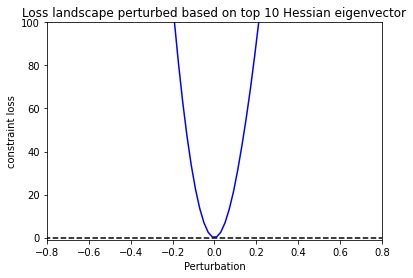

In [ ]:
# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams = np.linspace(-1, 1, 100).astype(np.float32)

loss_list = []
num_eig = 10
# model_perb = model_perb.cuda()
lowest = np.inf
for i in range(1):
    for lam in lams:
        par = init_params + lam * q
        loss_list.append(objective(par))
    plt.plot(lams, loss_list, color = (i/(num_eig+1),i/(num_eig+1),1))
    if min(loss_list) < lowest:
        lowest_idx = i
        lowest = min(loss_list)
    loss_list = []
    
plt.plot(np.array([-1, 1]), np.array([0, 0]), 'k--')
plt.ylabel('constraint loss')
plt.xlabel('Perturbation')
plt.ylim([-1,100])
plt.xlim([-0.8,.8])
plt.title('Loss landscape perturbed based on top 10 Hessian eigenvector')
print(f"The eigenvalue index with the lowest loss {lowest_idx+1}")

In [ ]:
fin_sprout['loadings'][:,0]

array([-0.80683649,  0.        ,  0.02820214, -0.41501571,  0.        ,
        0.1432579 ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.13509211, -0.03454207, -0.20587091, -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.14467402,
       -0.01232073, -0.03776994, -0.        , -0.        ,  0.        ,
        0.23461965, -0.12057524, -0.03923119, -0.        ,  0.        ,
        0.        ])

In [ ]:
import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.decomposition import SparsePCA
X, _ = make_friedman1(n_samples=200, n_features=5, random_state=0)
transformer = SparsePCA(n_components=5, random_state=0)
transformer.fit(X)
X_transformed = transformer.transform(X)
X_transformed.shape
# most values in the components_ are zero (sparsity)
np.mean(transformer.components_ == 0)

0.8

In [ ]:
transformer.get_params(deep=True)

{'U_init': None,
 'V_init': None,
 'alpha': 1,
 'max_iter': 1000,
 'method': 'lars',
 'n_components': 5,
 'n_jobs': None,
 'random_state': 0,
 'ridge_alpha': 0.01,
 'tol': 1e-08,
 'verbose': False}

In [ ]:
fin_sprout['x']

array([[-3.87157851e-01],
       [ 4.05375701e-02],
       [ 2.22137814e-01],
       [-3.80636913e-01],
       [ 4.06634922e-02],
       [ 2.18762781e-01],
       [-1.42105631e-01],
       [ 2.06505066e-02],
       [ 8.92296698e-02],
       [-1.42105629e-01],
       [ 2.06505084e-02],
       [ 8.92296698e-02],
       [ 1.62046688e-01],
       [-5.76964310e-02],
       [-1.01923966e-01],
       [ 3.70779511e-01],
       [-1.46005011e-01],
       [-2.49727629e-01],
       [ 1.40124323e-01],
       [-4.84108654e-02],
       [-8.60814434e-02],
       [ 1.31121459e-01],
       [-4.43788962e-02],
       [-7.93058815e-02],
       [ 2.75432818e-01],
       [-1.58908262e-01],
       [-1.07247652e-02],
       [ 1.00002825e-01],
       [-5.00929836e-02],
       [ 1.55364189e-03],
       [ 2.73266298e-01],
       [-1.58519952e-01],
       [-1.03214110e-02],
       [ 1.19069665e-01],
       [-6.12807646e-02],
       [ 1.25196768e-04]])

In [ ]:
L, sig, R = scipy.sparse.linalg.svds(hessian, k=2)

In [ ]:
import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.decomposition import SparsePCA
X, _ = make_friedman1(n_samples=200, n_features=30, random_state=0)
transformer = SparsePCA(n_components=10, random_state=0)
transformer.fit(X)
X_transformed = transformer.transform(X)
X_transformed.shape
np.mean(transformer.components_ == 0)

0.9666666666666667

In [ ]:
transformer.components_

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,

## Plot Purturbation along Eigenvalues Hessian

In [ ]:
ei, ev = np.linalg.eig(hessian)

In [ ]:
ei

array([ 4.2025199e+00+0.0000000e+00j,  2.3603423e+00+0.0000000e+00j,
        5.4929817e-01+0.0000000e+00j,  2.0912303e-01+0.0000000e+00j,
        1.8547523e-01+0.0000000e+00j,  1.0257223e-01+0.0000000e+00j,
        6.5023929e-02+0.0000000e+00j,  6.7669041e-02+0.0000000e+00j,
        2.4149166e-02+0.0000000e+00j,  2.2555443e-03+0.0000000e+00j,
       -1.4319941e-03+0.0000000e+00j,  1.0911843e-03+0.0000000e+00j,
       -7.1533967e-04+0.0000000e+00j,  7.6984259e-04+0.0000000e+00j,
        5.9094001e-04+0.0000000e+00j, -4.7961751e-04+0.0000000e+00j,
       -3.7124986e-04+0.0000000e+00j, -3.6167854e-04+0.0000000e+00j,
       -2.2443882e-04+0.0000000e+00j, -1.8208551e-04+0.0000000e+00j,
        3.6455298e-04+4.0759547e-05j,  3.6455298e-04-4.0759547e-05j,
        3.2256675e-04+0.0000000e+00j,  2.7701247e-04+0.0000000e+00j,
        1.9764047e-04+0.0000000e+00j,  1.6951197e-04+2.3164384e-05j,
        1.6951197e-04-2.3164384e-05j,  1.0111631e-04+0.0000000e+00j,
        7.7004232e-05+0.0000000e+0

In [ ]:
np.diag(hessian)

array([0.4031444 , 0.4017197 , 0.21731584, 0.41154957, 0.41958198,
       0.22265382, 0.14144665, 0.04155198, 0.05558305, 0.14144665,
       0.04155198, 0.05558305, 0.19241923, 0.05598437, 0.14994377,
       0.440924  , 0.18470444, 0.38486615, 0.13172337, 0.02456327,
       0.09272429, 0.11238349, 0.01391564, 0.07390076, 0.31038952,
       0.38774738, 0.657815  , 0.07627688, 0.04741968, 0.19988532,
       0.29066476, 0.36058742, 0.631536  , 0.09310511, 0.07185332,
       0.23061322], dtype=float32)

The eigenvalue index with the lowest loss 1


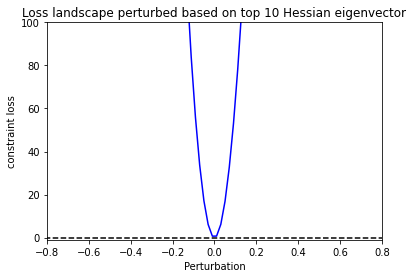

In [ ]:
# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams = np.linspace(-1, 1, 100).astype(np.float32)

loss_list = []
num_eig = 10
# model_perb = model_perb.cuda()
lowest = np.inf
for i in range(1):
    for lam in lams:
        par = init_params + lam * fin_sprout['loadings'][:,0]
        loss_list.append(objective(par))
    plt.plot(lams, loss_list, color = (i/(num_eig+1),i/(num_eig+1),1))
    if min(loss_list) < lowest:
        lowest_idx = i
        lowest = min(loss_list)
    loss_list = []
    
plt.plot(np.array([-1, 1]), np.array([0, 0]), 'k--')
plt.ylabel('constraint loss')
plt.xlabel('Perturbation')
plt.ylim([-1,100])
plt.xlim([-0.8,.8])
plt.title('Loss landscape perturbed based on top 10 Hessian eigenvector')
print(f"The eigenvalue index with the lowest loss {lowest_idx+1}")

## Plot Purturbation along Gradient

In [ ]:
gradient = egrad(dist_loss)(init_params)

The eigenvalue index with the lowest loss 3


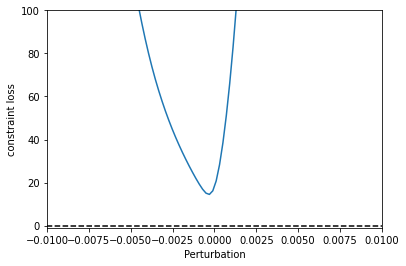

In [ ]:
# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams = np.linspace(-0.01, 0.01, 100).astype(np.float32)

loss_list = []
lowest = np.inf
for lam in lams:
    par = init_params + lam * gradient
    loss_list.append(dist_loss(par))
plt.plot(lams, loss_list)
    
plt.plot(np.array([-1, 1]), np.array([0, 0]), 'k--')
plt.ylabel('constraint loss')
plt.xlabel('Perturbation')
plt.ylim([-1,100])
plt.xlim([-0.01,.01])
# plt.title('Loss landscape perturbed based on top 10 Hessian eigenvector')
print(f"The eigenvalue index with the lowest loss {lowest_idx+1}")

In [ ]:
loss_list

[7.9432528601957975,
 7.617230974360735,
 7.2982207664093774,
 6.9862238029177455,
 6.681228157416095,
 6.3832248067905155,
 6.0921731471471094,
 5.808112258995247,
 5.530994322796793,
 5.260813904007896,
 4.997584199055959,
 4.741261229780208,
 4.491861725445206,
 4.249350337798676,
 4.013741725946009,
 3.7850076104605224,
 3.563133309526152,
 3.3481341441148853,
 3.1399749678181923,
 2.9386607197934165,
 2.74416235472369,
 2.5564846882006087,
 2.3756080540203763,
 2.20152974902844,
 2.034268180685326,
 1.8737806538517336,
 1.7200563608562225,
 1.5730730209765391,
 1.432836051427919,
 1.2993368766135664,
 1.172545554456065,
 1.0524768008696175,
 0.9391021368795573,
 0.8324119798588723,
 0.7324002586708154,
 0.6390580509713031,
 0.5523769617673265,
 0.4723420674133317,
 0.3989378724975533,
 0.33216561521240023,
 0.27200981351099973,
 0.21845638291760933,
 0.17150009518826945,
 0.13112604147671786,
 0.0973282797332892,
 0.0700937350581472,
 0.049412724636647615,
 0.03527552084105452,
 0

# Train Pytorch Model

In [ ]:
gradient

array([ -0.33911863,  51.335075  ,  22.589079  ,  72.18899   ,
         6.237887  , -33.60863   ,   1.9071463 ,  -5.4591465 ,
        -2.656078  ,   1.9071463 ,  -5.4591465 ,  -2.656078  ,
       -29.091063  ,  20.501717  ,  42.2481    ,  34.147522  ,
        11.16419   ,  37.153915  ,  20.835033  ,  -2.3427541 ,
         0.1281082 ,  -5.2785683 ,  -0.5420822 ,  -2.8286939 ,
        39.32185   ,   9.234743  ,   0.        , -12.650524  ,
        22.894392  ,   0.        ,   0.35996   ,  61.934345  ,
         0.        ,  -4.2426405 ,  -4.2426405 ,   0.        ],
      dtype=float32)

In [ ]:
# # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# input_size = 3
# output_size = 3
# batch_size = 100
# lr = 0.004
# epochs = 10000

NameError: name 'torch' is not defined

In [ ]:
def original_data_loader():
    if not os.path. exists ("tc1/data/input_output_data_tc1.pickle"):
        raise ImportError(
            "path data/input_output_data_tc1.pickle does not exist!"
        )
    with open ("tc1/data/input_output_data_tc1.pickle", "rb") as data:
        dataset = pickle.load (data)
    return dataset[0], dataset[1], dataset[2], dataset[3]

In [ ]:
class neural_network(nn.Module):
    def __init__(self, input_size, output_size):
        super(neural_network, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=3)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=3, out_features=3)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=3, out_features=output_size)
    
    def forward(self, x):
#         print(x)
        x = self.fc1(x)
#         print(x)
        x = self.act1(x)
#         print(x)
        x = self.fc2(x)
#         print(x)
        x = self.act2(x)
#         print(x)
        x = self.fc3(x)
#         print(x)
        
        return x

In [ ]:
model = neural_network(input_size, output_size)
x_train, y_train, x_test, y_test = original_data_loader()
inputs_train = torch.tensor(x_train)
targets_train = torch.tensor(y_train)
inputs_test = torch.tensor(x_test)
targets_test = torch.tensor(y_test)

In [ ]:
def get_params(model_torch, weights):
    for m_perb, d in zip(model_torch.parameters(), weights):
        m_perb.data = torch.tensor(d).T
    return model_torch

In [ ]:
model = get_params(model,weights)

/var/folders/7v/7wknzt0d797gn2p62b8394yc0000gn/T/ipykernel_9820/4134496133.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2318.)
  m_perb.data = torch.tensor(d).T


In [ ]:
# def dist_loss(y_pred, y_target):
#     A = np.array([[1,1],[1,1],[-1,1],[-1,1]])
#     b = np.array([1,3,1,-1])
#     violate = (np.matmul(A,y_pred.float()[:,0:2].T) + b).T
#     loss = 0 
#     for i in range(violate.shape[0]):
#         if (violate[i]<0).any():
#             dist = np.inf
#             for l in list(np.where(violate[i]<0)[0]):
#                 dist = 2

### distance loss
Asssuming we are given a constraint of the for $Ax\leq b$:
\begin{align}
\sum^{N}_{n=1}\sum^{C}_{c=1}ReLU(a_cx-b_c)
\end{align}
where $N$ is the number of samples and $C$ is the number of inequality constraints.

In [ ]:
def dist_loss(y_pred, y_target):
    A = np.array([[-0.70710678,  0.70710678],
       [ 0.70710678,  0.70710678],
       [-0.70710678, -0.70710678],
       [ 0.70710678, -0.70710678]])
    b = np.array([[ 1.225     ],
       [ 4.76053391],
       [-2.31053391],
       [ 1.225     ]])
    loss = torch.sum(torch.relu(torch.matmul(torch.tensor(A).float(),y_pred[:,0:2].float().T) - torch.tensor(b).float()))
    return loss

In [ ]:
targets_train[0:2]

tensor([[3.4800, 3.6146, 1.0000],
        [2.2423, 1.2879, 1.0000]], dtype=torch.float64)

In [ ]:
dist_loss(targets_train[0:1], targets_train[0:1])

tensor(0.2562)

In [ ]:
criterion = dist_loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# # Loss and optimizer


# # Train the network
# for epoch in range(epochs):
#     for batch, (data, target) in enumerate(train_loader):
#         # clear the gradients
#         optimizer.zero_grad()
#         # compute the model output
#         yhat = model(data.float())
#         # calculate loss
#         loss = criterion(yhat.float(), target.float())
#         # credit assignment
#         loss.backward()
#         # update model weights
#         optimizer.step()

In [ ]:
# evaluate the model
def evaluate_model(inputs, targets, model):
    predictions, actuals = list(), list()
    # evaluate the model on the test set
    yhat = model(inputs.float())
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    actual = targets.numpy()
#         actual = actual.reshape((len(actual), 1))
    # store
    predictions.append(yhat)
    actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate mse
    mse = mean_squared_error(actuals, predictions)
    return mse

In [ ]:
mse = evaluate_model(inputs_test,targets_test, model)
print('MSE: %.3f, RMSE: %.3f' % (mse, np.sqrt(mse)))

MSE: 0.000, RMSE: 0.007


In [ ]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([model_orig.layers[0].input],
                                  [model_orig.layers[2].output])
layer_output = get_3rd_layer_output([x_test[0:1]])[0]

In [ ]:
model_orig.predict(x_test[0:3])

2022-04-27 11:29:37.658438: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


array([[3.2112792 , 1.6994811 , 0.99400204],
       [1.0975695 , 1.8461307 , 0.9837373 ],
       [0.7131818 , 2.2089243 , 0.98410827]], dtype=float32)

In [ ]:
y_hat = model(inputs_test.float()).detach().numpy()

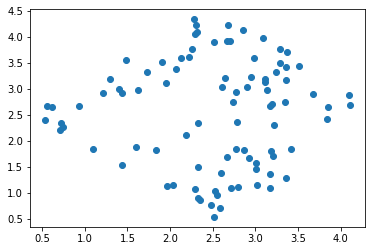

In [ ]:
plt.scatter(y_hat[:,0], y_hat[:,1])

In [ ]:
# summary(model.cuda(), input_size=(1, 3))

## Example 1: Power Iteration with Numpy

The following part shows how to use power iteration to get the top eigenvalue of a matrix without explicitly having access to it in numpy. We start by creating a random matrix B, compute its ground truth eigenvalues using numpy, and then compare the results with matrix-free power iteration (which does not need direct access to the matrix).

In [ ]:
n = 10 # the matrix size

# generate a random matrix
A = np.random.randn(n, n)
B = A @ A.T

Now let's use numpy to compute the ground truth eigenvalues. We will then check the results with this.

In [ ]:
# use np.eigs to get the top eigenvalue of B
eigs, _ = np.linalg.eig(B)

print("The top eigenvalue of B is %.4f"%np.sort(eigs)[-1])

The top eigenvalue of B is 32.5401


Now let's try to comptue the top eigenvalue of B without explicitly accessing B. To do so, we will use a method called Power Iteration:

https://en.wikipedia.org/wiki/Power_iteration

The algorithm is very simple and efficiet to compute the top eigenvalue:
$$v_{i+1} = \frac{Bv_i}{\|Bv_i\|}.$$

As such, we only need to have access to the *application* of B to a given vector $v_i$ and not the matrix B itself. This application is commonly referred to as *matvec* in literature.

In [ ]:
# use power iteration to get the top eigenvalue of B
v = np.random.randn(n, 1)
for i in range(40):
    v = v / np.linalg.norm(v)
    eig_power_iteration = v.T @ B @ v
    print("Step %2d current estimated top eigvalue: %.4f"%(i+1,eig_power_iteration))
    v = B @ v
print("Finished Power Iteration\n")
print("Ground Truth Top Eigenvalue: %.4f"%np.sort(eigs)[-1])
print("Result with matrix-free Power Iteration: %.4f"%eig_power_iteration)

Step  1 current estimated top eigvalue: 5.1071
Step  2 current estimated top eigvalue: 19.3202
Step  3 current estimated top eigvalue: 27.8266
Step  4 current estimated top eigvalue: 30.9717
Step  5 current estimated top eigvalue: 31.9463
Step  6 current estimated top eigvalue: 32.2950
Step  7 current estimated top eigvalue: 32.4357
Step  8 current estimated top eigvalue: 32.4953
Step  9 current estimated top eigvalue: 32.5208
Step 10 current estimated top eigvalue: 32.5318
Step 11 current estimated top eigvalue: 32.5366
Step 12 current estimated top eigvalue: 32.5386
Step 13 current estimated top eigvalue: 32.5395
Step 14 current estimated top eigvalue: 32.5399
Step 15 current estimated top eigvalue: 32.5400
Step 16 current estimated top eigvalue: 32.5401
Step 17 current estimated top eigvalue: 32.5401
Step 18 current estimated top eigvalue: 32.5401
Step 19 current estimated top eigvalue: 32.5401
Step 20 current estimated top eigvalue: 32.5401
Step 21 current estimated top eigvalue: 3

As you can see the result of the power iteration and the one we got from numpy match very well.

We can apply the same techinique for neural networks as well, and in particular use it to compute eigenvalues of Hessian!

Importantly there has been a lot of misconception that we can not use Hessian for real world applications since
we need to explicitly form it. Next you will see that this is not correct.

## Example 2: Power Iteration for NN Hessian

In [ ]:
# get the model 
# model = ptcv_get_model("resnet20_cifar10", pretrained=True)
# change the model to eval mode to disable running stats upate
model.eval()

# create loss function
# criterion = torch.nn.CrossEntropyLoss()

# get dataset 
# train_loader, test_loader = getData()

# for illustrate, we only use one batch to do the tutorial
inputs=torch.tensor(x_train)
targets=torch.tensor(y_train)

# we use cuda to make the computation fast
# model = model.cuda()
# inputs, targets = inputs.cuda(), targets.cuda()



In [ ]:
# create the hessian computation module
hessian_comp = hessian(model, criterion, data=(inputs.float(), targets.float()), cuda=False)

/usr/local/lib/python3.9/site-packages/torch/autograd/__init__.py:173: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/autograd/engine.cpp:985.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [ ]:
# Now let's compute the top eigenvalue. This only takes a few seconds.
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
print("The top Hessian eigenvalue of this model is %.4f"%top_eigenvalues[-1])

The top Hessian eigenvalue of this model is 110.9845


In [ ]:
# Now let's compute the top 2 eigenavlues and eigenvectors of the Hessian
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
print("The top two eigenvalues of this model are: %.4f %.4f"% (top_eigenvalues[-1],top_eigenvalues[-2]))

The top two eigenvalues of this model are: -100.7496 129.9854


In [ ]:
hessian_comp.trace()

[-226.77090454101562,
 114.70587158203125,
 182.3402099609375,
 -1010.2050170898438,
 -142.07672119140625,
 -281.20135498046875,
 -123.55567932128906,
 199.6807861328125,
 544.0047607421875,
 -889.7408447265625,
 382.8859558105469,
 339.1649169921875,
 182.03224182128906,
 -187.91867065429688,
 -552.0142211914062,
 594.6582641601562,
 298.1199645996094,
 10.404312133789062,
 -403.1482849121094,
 579.6893310546875,
 -272.2691955566406,
 297.3062744140625,
 102.3587417602539,
 -216.55526733398438,
 504.30126953125,
 131.79937744140625,
 -338.3074951171875,
 -112.15074157714844,
 125.50126647949219,
 1272.19921875,
 5.5571441650390625,
 402.0695495605469,
 -702.1671142578125,
 614.4099731445312,
 605.1615600585938,
 216.01629638671875,
 -544.8174438476562,
 -173.20205688476562,
 -717.4808959960938,
 -389.67486572265625,
 -217.10202026367188,
 -88.54679870605469,
 12.884368896484375,
 -38.13508605957031,
 499.59967041015625,
 591.2803955078125,
 721.6129150390625,
 -904.3590087890625,
 187

The small difference between this top eigenvalue (195.4954) and the previous one (195.5897) is due to the small number of iterations that we used in Power iteration. You can remove this small difference by increasing the number of iterations for power iteration.

## Example 2.1: Plot Loss Landscape

We can use the Hessian eigenvectors/eigenvalues to analyze the flat/sharpness of the loss landscape of your model, and plot the loss landscape. We will show that this can be more informative than using random directions.

To plot the loss landscape, we first compute the top Hessian eigenvector and then perturb the model parameters along that direction and measure the loss.

In [ ]:
import copy

In [ ]:
hessian_comp.eigenvalues()

([129.69361877441406],
 [[tensor([[ 0.1492,  0.5109, -0.0027],
           [ 0.0283,  0.2206, -0.0015],
           [-0.0520, -0.1330,  0.0047]]),
   tensor([-0.0027, -0.0015,  0.0047]),
   tensor([[-0.2417, -0.1674,  0.0285],
           [ 0.1960,  0.1169, -0.0288],
           [ 0.3862,  0.2207, -0.0613]]),
   tensor([ 0.0055, -0.0041, -0.0073]),
   tensor([[ 0.0633, -0.1074, -0.2181],
           [-0.1893,  0.2091,  0.4027],
           [ 0.0000,  0.0000,  0.0000]]),
   tensor([0., 0., 0.])]])

In [ ]:
# get the top eigenvector
num_eig = 10
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(maxIter=10000, top_n = num_eig)

In [ ]:
# This is a simple function, that will allow us to perturb the model paramters and get the result
def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

The eigenvalue index with the lowest loss 9


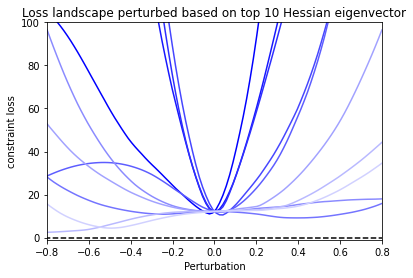

In [ ]:
# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams = np.linspace(-0.8, 0.8, 100).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = copy.deepcopy(model)
model_perb.eval()
# model_perb = model_perb.cuda()
lowest = np.inf
for i in range(num_eig):
    for lam in lams:
        model_perb = get_params(model, model_perb, top_eigenvector[i], lam)
        loss_list.append(criterion(model_perb(inputs.float()), targets.float()).item())
    plt.plot(lams, loss_list, color = (i/(num_eig+1),i/(num_eig+1),1))
    if min(loss_list) < lowest:
        lowest_idx = i
        lowest = min(loss_list)
    loss_list = []
    
plt.plot(np.array([-1, 1]), np.array([0, 0]), 'k--')
plt.ylabel('constraint loss')
plt.xlabel('Perturbation')
plt.ylim([-1,100])
plt.xlim([-0.8,.8])
plt.title('Loss landscape perturbed based on top 10 Hessian eigenvector')
print(f"The eigenvalue index with the lowest loss {lowest_idx+1}")

In [ ]:
top_eigenvalues

[129.7122039794922,
 -117.45628356933594,
 115.83407592773438,
 112.68498229980469,
 -80.87095642089844,
 -71.99787139892578,
 70.35491943359375,
 65.60148620605469,
 -65.58497619628906,
 -61.28729248046875]

In [ ]:
top_eigenvector

[[tensor([[ 1.1374e-01,  5.1444e-01,  1.1716e-03],
          [ 2.0921e-02,  2.7048e-01, -3.5368e-04],
          [-3.8899e-02, -1.1415e-01,  3.3725e-03]]),
  tensor([ 0.0012, -0.0004,  0.0034]),
  tensor([[-0.2107, -0.1269,  0.0323],
          [ 0.1963,  0.0991, -0.0359],
          [ 0.3999,  0.1924, -0.0775]]),
  tensor([ 0.0040, -0.0033, -0.0059]),
  tensor([[ 0.0706, -0.0958, -0.1853],
          [-0.2390,  0.2212,  0.4068],
          [ 0.0000,  0.0000,  0.0000]]),
  tensor([0., 0., 0.])],
 [tensor([[ 0.3362, -0.0864, -0.0382],
          [ 0.0878, -0.4184, -0.0123],
          [-0.1177, -0.1339,  0.0117]]),
  tensor([-0.0382, -0.0123,  0.0117]),
  tensor([[-0.2229, -0.3505, -0.0506],
          [-0.0189,  0.1666,  0.0723],
          [-0.1394,  0.2770,  0.1609]]),
  tensor([ 0.0128, -0.0081, -0.0134]),
  tensor([[-0.0999, -0.0825, -0.2608],
          [ 0.4822, -0.1123, -0.0262],
          [ 0.0000,  0.0000,  0.0000]]),
  tensor([0., 0., 0.])],
 [tensor([[-0.3078,  0.2137,  0.0385],
     

In [ ]:
layer1 = []
layer2 = []
layer3 = []
for vec in top_eigenvector:
    layer1.append(torch.norm(vec[0], np.inf))
    layer2.append(torch.norm(vec[2], np.inf))
    layer3.append(torch.norm(vec[4], np.inf))

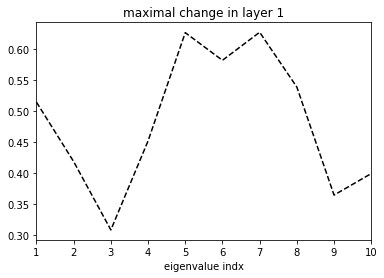

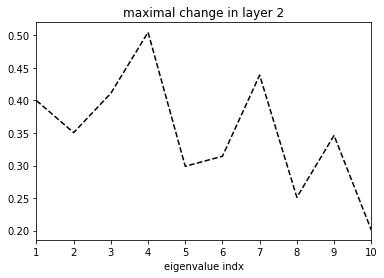

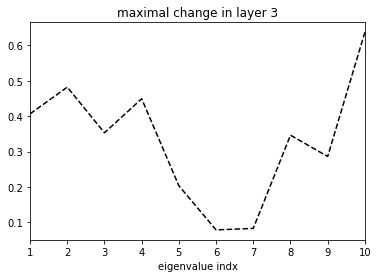

In [ ]:
plt.plot(np.linspace(1, 10, 10),layer1, 'k--')
plt.xlabel('eigenvalue indx')
plt.xlim([1,10])
plt.title('maximal change in layer 1')
plt.show()

plt.plot(np.linspace(1, 10, 10),layer2, 'k--')
plt.xlabel('eigenvalue indx')
plt.xlim([1,10])
plt.title('maximal change in layer 2')
plt.show()

plt.plot(np.linspace(1, 10, 10),layer3, 'k--')
plt.xlabel('eigenvalue indx')
plt.xlim([1,10])
plt.title('maximal change in layer 3')
plt.show()

In [ ]:
layer1 = []
layer2 = []
layer3 = []
for vec in top_eigenvector:
    layer1.append(torch.mean(vec[0]))
    layer2.append(torch.mean(vec[2]))
    layer3.append(torch.mean(vec[4]))

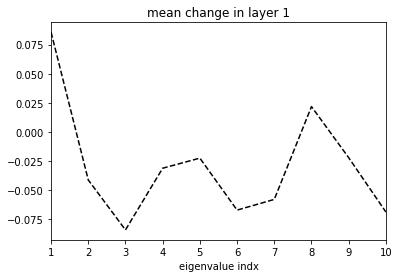

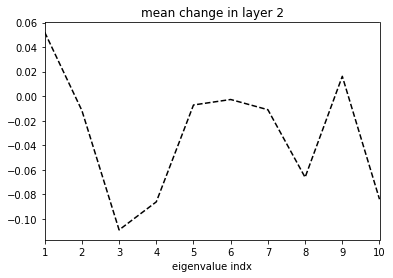

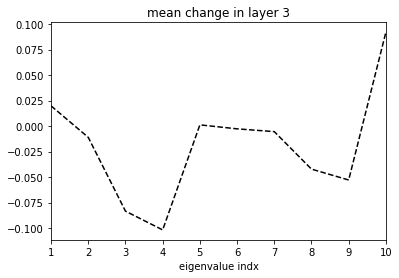

In [ ]:
plt.plot(np.linspace(1, 10, 10),layer1, 'k--')
plt.xlabel('eigenvalue indx')
plt.xlim([1,10])
plt.title('mean change in layer 1')
plt.show()

plt.plot(np.linspace(1, 10, 10),layer2, 'k--')
plt.xlabel('eigenvalue indx')
plt.xlim([1,10])
plt.title('mean change in layer 2')
plt.show()

plt.plot(np.linspace(1, 10, 10),layer3, 'k--')
plt.xlabel('eigenvalue indx')
plt.xlim([1,10])
plt.title('mean change in layer 3')
plt.show()

In [ ]:
torch.norm(top_eigenvector[0][5], np.inf)

tensor(0.)

In [ ]:
# # lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
# lams = np.linspace(-0.5, 0.5, 100).astype(np.float32)

# loss_list = []

# # create a copy of the model
# model_perb = copy.deepcopy(model)
# model_perb.eval()
# # model_perb = model_perb.cuda()

# for lam in lams:
#     model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
#     loss_list.append(criterion(model_perb(inputs.float()), targets.float()).item())

# plt.plot(lams, loss_list)
# plt.ylabel('constraint')
# plt.xlabel('Perturbation')
# plt.title('Loss landscape perturbed based on top Hessian eigenvector')

In [ ]:
min(loss_list)

ValueError: min() arg is an empty sequence

Now let's compare this with a loss landscape computed based on perturbing the model parameters along a random direction.

Text(0.5, 1.0, 'Loss landscape perturbed based on a random direction')

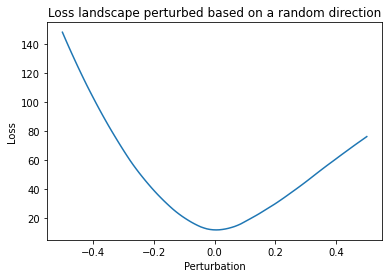

In [ ]:
from pyhessian.utils import normalization

# generate random vector to do the loss plot

v = [torch.randn_like(p) for p in model.parameters()]
v = normalization(v)


# used to perturb your model 
lams = np.linspace(-0.5, 0.5, 100).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = copy.deepcopy(model)
model_perb.eval()
# model_perb = model_perb.cuda()

for lam in lams: 
    model_perb = get_params(model, model_perb, v, lam)
    loss_list.append(criterion(model_perb(inputs.float()), targets.float()).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on a random direction')

In [ ]:
min(loss_list)

12.14783763885498

Note how different the loss landscape looks. In particular note that there is almost no change in the loss value (see the small scale of the y-axis). This is expected, since for a converged NN, many of the directions are typically degenarate (i.e. they are flat).

We can also use gradient direction to perturb the model. While gradient is better than random vector, but it is not possible to use it to plot 3D loss landscape since you will need more than one direction. However, you can use top 2 Hessian vectors instead for that scenario.

Text(0.5, 1.0, 'Loss landscape perturbed based on gradient direction')

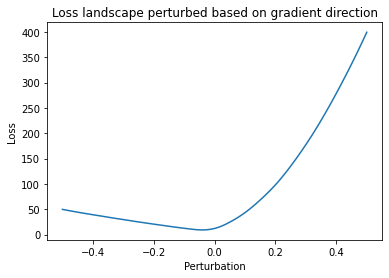

In [ ]:
from pyhessian.utils import normalization


# used to perturb your model 
lams = np.linspace(-0.5, 0.5, 100).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = copy.deepcopy(model)
model_perb.eval()
# model_perb = model_perb.cuda()

# generate gradient vector to do the loss plot
loss = criterion(model_perb(inputs.float()), targets.float())
loss.backward()

v = [p.grad.data for p in model_perb.parameters()]
v = normalization(v)
model_perb.zero_grad()


for lam in lams: 
    model_perb = get_params(model, model_perb, v, lam)
    loss_list.append(criterion(model_perb(inputs.float()), targets.float()).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on gradient direction')

In [ ]:
min(loss_list)

0.044786807149648666

## Example 3: Hessian Trace/Diagonal
We can also use randomized linear algebra to compute Hessian trace or approximate the Hessian diagonal with very little computational overhead. Let's first start with a numpy example, and then we will show results for a NN.

In [ ]:
n = 1000 # the matrix size

# generate the matrix
A = np.random.randn(n, n)
B = A @ A.T

In [ ]:
# Direct get the trace 
trace_B_np = np.matrix.trace(B)
print("The trace of B is: %.4f"%trace_B_np)

The trace of B is: 998352.3467


We can approximate the above by using Hutchinson Method. It is very similar to power iteration:

$$Tr(B) = \mathbb{E}[v^TBv],$$
$$Diag(B) = \mathbb{E}[v \bigodot Bv].$$

It can be proved that the above expectation converges with smallest variance to the trace if we use Rademacher random numbers (+/-1). In practice you can also use Gaussian random vectors as well.

In [ ]:
# use Hutchinson method to get the trace of B
trace_list = []

for i in range(20):
    v = np.random.randint(2, size=n) 
    v = v.reshape(n, 1) * 2 - 1 # Create Rademacher random numbers
    trace_list.append(v.T @ B @ v)
    trace_B_hutchinson = np.mean(trace_list)
    print("Step %.2d, Current estimated trace: %.1f relative error: %.1e"
          %(i+1, trace_B_hutchinson, (trace_B_hutchinson - trace_B_np) / trace_B_np))

Step 01, Current estimated trace: 977887.5 relative error: -2.0e-02
Step 02, Current estimated trace: 1014029.1 relative error: 1.6e-02
Step 03, Current estimated trace: 1011741.3 relative error: 1.3e-02
Step 04, Current estimated trace: 1015957.3 relative error: 1.8e-02
Step 05, Current estimated trace: 1014763.1 relative error: 1.6e-02
Step 06, Current estimated trace: 1001286.1 relative error: 2.9e-03
Step 07, Current estimated trace: 995993.6 relative error: -2.4e-03
Step 08, Current estimated trace: 988758.3 relative error: -9.6e-03
Step 09, Current estimated trace: 1001076.4 relative error: 2.7e-03
Step 10, Current estimated trace: 1005864.0 relative error: 7.5e-03
Step 11, Current estimated trace: 1009536.9 relative error: 1.1e-02
Step 12, Current estimated trace: 1013412.7 relative error: 1.5e-02
Step 13, Current estimated trace: 1018004.5 relative error: 2.0e-02
Step 14, Current estimated trace: 1014781.1 relative error: 1.6e-02
Step 15, Current estimated trace: 1012993.5 rela

As you can see we can get a very accurate estimate of the trace. Next let's try to approximate the diagonal of B using the matrix-free Hutchinson's method.

In [ ]:
# use Hutchinson method to get the diag of B
diag_est = np.zeros([n, 1])
diag_B_np = np.diag(B)
for i in range(20):
    v = np.random.randint(2, size=n)
    v = v.reshape(n, 1) * 2 - 1
    diag_est += np.multiply(v, (B @ v))
    diag_est_err = np.mean(np.abs(diag_est.reshape(-1) / (i+1) - diag_B_np) / diag_B_np)
    print("Step %.2d, the current average relative error %.1e:"%(i+1,diag_est_err))

Step 01, the current average relative error 8.1e-01:
Step 02, the current average relative error 5.8e-01:
Step 03, the current average relative error 4.9e-01:
Step 04, the current average relative error 4.2e-01:
Step 05, the current average relative error 3.7e-01:
Step 06, the current average relative error 3.3e-01:
Step 07, the current average relative error 3.1e-01:
Step 08, the current average relative error 2.9e-01:
Step 09, the current average relative error 2.7e-01:
Step 10, the current average relative error 2.6e-01:
Step 11, the current average relative error 2.5e-01:
Step 12, the current average relative error 2.4e-01:
Step 13, the current average relative error 2.3e-01:
Step 14, the current average relative error 2.2e-01:
Step 15, the current average relative error 2.1e-01:
Step 16, the current average relative error 2.0e-01:
Step 17, the current average relative error 1.9e-01:
Step 18, the current average relative error 1.9e-01:
Step 19, the current average relative error 1.

In [ ]:
diag_est.shape

(1000, 1)

Now let's repeate the above for computing the trace and diagonal of Hessian for ResNet20.

In [ ]:
# get the model 
# model = ptcv_get_model("resnet20_cifar10", pretrained=True)
# change the model to eval mode to disable running stats upate
model.eval()

# create loss function
# criterion = torch.nn.CrossEntropyLoss()

# get dataset 
# train_loader, test_loader = getData()

# for illustrate, we only use one batch to do the tutorial
inputs=torch.tensor(x_train)
targets=torch.tensor(y_train)

# we use cuda to make the computation fast
# model = model.cuda()
# inputs, targets = inputs.cuda(), targets.cuda()

In [ ]:
# create the hessian computation module
hessian_comp = hessian(model, criterion, data=(inputs.float(), targets.float()), cuda=False)

In [ ]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 82.5816


In [ ]:
hessian_comp.eigenvalues(top_n=1)

([38.23210906982422],
 [[tensor([[ 0.3825,  0.3674,  0.1414],
           [-0.0845, -0.0811, -0.0312],
           [-0.2306, -0.2213, -0.0853]]),
   tensor([ 0.1414, -0.0312, -0.0853]),
   tensor([[-0.1690, -0.4035, -0.1470],
           [ 0.0552,  0.1318,  0.0480],
           [ 0.0906,  0.2162,  0.0787]]),
   tensor([-0.1338,  0.0437,  0.0717]),
   tensor([[-0.2906, -0.0993, -0.2887],
           [ 0.1202,  0.0411,  0.1195],
           [-0.0058, -0.0021, -0.0060]]),
   tensor([-0.1182,  0.0489, -0.0024])]])

We can also get the full eigenvalue spectrum density of Hessian using Stochastic Lancoz algorithm.

In [ ]:
density_eigen, density_weight = hessian_comp.density()

/home/local/ASUAD/kmajd1/Documents/PyHessian/pyhessian/hessian.py:261: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2894.)
  a_, b_ = torch.eig(T, eigenvectors=True)


In [ ]:
len(density_eigen[0])

100

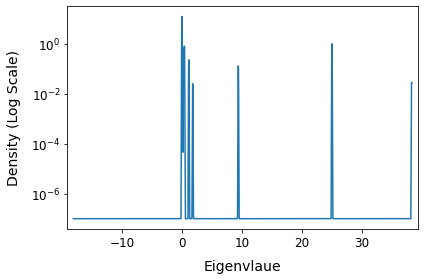

In [ ]:
get_esd_plot(density_eigen, density_weight)

The above ESD plot is very interesting and shows that a lot of the eigenvalues of the Hessian are close to zero. This means that a lot of the directions along the loss landscape is almost flat. We expect this based on the loss landscape that we got above when we used a random direction. Another interesting observation is that there are several large Hessian outliers. The other very interesting finding, is that there are a lot of directions with slight negative curvature. This means that we still have not converged to a perfect local minimum that satisfies first and second order optimality conditions.